In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libs

In [2]:
# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Загрузка сохраненной модели
from tensorflow.keras.models import load_model

# Готовые датасеты
from tensorflow.keras.datasets import mnist, fashion_mnist

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

# класс для использования Functional API
from tensorflow.keras import Model

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split 

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Функции операционной системы
import os

# Работа со временем
import time

# Отрисовка графиков
import matplotlib.pyplot as plt 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import os
# Работа со временем
import time
from scipy.ndimage import zoom
import random
IMG_HEIGHT, IMG_WIDTH = 512, 128 ## todo
VAL_SPLIT = 0.1

## Giperparams

In [3]:
IMG_HEIGHT, IMG_WIDTH = 128, 128
VAL_SPLIT = 0.1

## Dataset manipulation

In [4]:
folder = 'drive/MyDrive/dataset/'
# os.listdir(folder)

In [5]:
def load_bscans(folder, height, width): 
    bscans_list = []                       # Список для радарограмм
    geometry_list = []
    for bscan in os.listdir(folder):        # Перебор по именам файлов в папке
        # Добавление в список изображения в виде массива,
        # в заданных размерах и в оттенках серого
        if 'bscan_' in bscan:
            bscans_list.append(zoom(np.load(os.path.join(folder, bscan)), (1,0.25)).T)
            # print(folder+'\\'+bscan)
            geom_name=f'geom{bscan[5:-4]}.npy'
            geom_np = np.load(os.path.join(folder, geom_name))
            new_geom = np.zeros((128, 128, 2),)
            new_geom[:,:,0] = 6 # наиболее часто встречающееся число
            new_geom[:,:,1] = 1 # наиболее часто встречающееся число
            new_geom[:126,:125,:2] = geom_np
            
            geometry_list.append(new_geom)
                
            
    # Возврат массива-результата
    return np.array(bscans_list), np.array(geometry_list)

# Загрузка датасета в память
cur_time = time.time()
data_bscans, data_geometry = load_bscans(folder, IMG_HEIGHT, IMG_WIDTH)
print(f'Время загрузки: {round(time.time()-cur_time)} с.')
data_bscans = data_bscans.reshape([data_bscans.shape[0], 
                                   data_bscans.shape[1], 
                                   data_bscans.shape[2], 
                                   1])
data_geometry = data_geometry[:,:,:,0].reshape([data_bscans.shape[0], 
                                   data_bscans.shape[1], 
                                   data_bscans.shape[2], 
                                   1])

# data_geometry = np.where(data_geometry == 1, 100, data_geometry)

Время загрузки: 9 с.


In [7]:
# from sklearn import preprocessing
# data_geometry = preprocessing.normalize([data_geometry])
def normalization(dataset):
  max = dataset.max()
  min = dataset.min()
  dataset = (dataset -min)/(max - min)
  return dataset.astype(float)

data_geometry = normalization(data_geometry)
data_bscans = normalization(data_bscans)

109
(128, 128, 1)


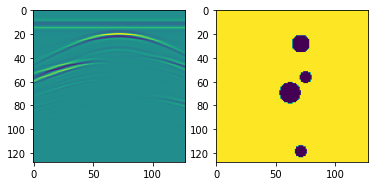

In [10]:
rand = random.randint(1, len(data_bscans)-1)
print(rand)
bscan = data_bscans[rand]
geom = data_geometry[rand]
print(geom.shape)


fig, ax = plt.subplots(1, 2)
ax[0].imshow(bscan[:, :,0])
ax[1].imshow(geom[:, :,0])
# ax[2].imshow(geom[:, :, 1])
# ax[1].imshow(npy[:, :, 1])
plt.show()
        # plt.close()

In [34]:
# data_bscans = data_bscans.astype('float32') / 255.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    data_bscans, data_geometry, 
    test_size=VAL_SPLIT, 
    random_state=42)

## Service functions

In [12]:
def process_images(model,        # обученная модель
                   count = 3     # количество случайных картинок для сегментации
                   ):
  
    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
  indexes = np.random.randint(0, len(X_test), count)

  bscans = X_test[indexes]
  orig_geom = y_test[indexes]
  # Вычисление предсказания сети для картинок с отобранными индексами
  predict = np.argmax(model.predict(bscans), axis=-1)


  # Подготовка цветов классов для отрисовки предсказания

  fig, axs = plt.subplots(count, 3, figsize=(25, 15)) 
  for i in range(count):
      # Отображение на графике в первой линии предсказания модели
      axs[0, 0].set_title('Bscan:')
      axs[i, 0].imshow(bscans[i][:,:,0])
      axs[i, 0].axis('off')

      # Отображение на графике во второй линии сегментированного изображения из y_val
      axs[0, 1].set_title('Orig_geom')
      axs[i, 1].imshow(orig_geom[i][:,:,0])
      axs[i ,1].axis('off')

      # Отображение на графике в третьей линии оригинального изображения
      axs[0, 2].set_title('Pred_geom')
      axs[i, 2].imshow(predict[i])
      axs[i ,2].axis('off')

  plt.show() 

## Нейронка Автокодер

### Func

In [13]:
# Функция сборки свёрточного автокодировщика
def create_base_ae(in_shape):

  # Входной слой 
  inputs = Input(in_shape)

  # Энкодер
  # ---------------------------------------------------------------

  # 3 блока свертки перед сжатием 
  x = Conv2D(12, 3, padding='same', activation='relu')(inputs)
  x = BatchNormalization()(x)

  # используем разрежение (dilation_rate) для выявления мелких деталей изображения
  x = Conv2D(24, 3, dilation_rate=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 1
  x = Conv2D(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(96, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 2
  x = Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(256, 3, padding='same', activation='relu')(x)

  # Скрытое пространство
  z = BatchNormalization()(x)

  # Декодер
  # ---------------------------------------------------------------
  # Расширение 2
  x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(z)
  x = BatchNormalization()(x)

  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Расширение 1
  x = Conv2DTranspose(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(24, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(8, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # финальный слой свертки, выход модели
  outputs = Conv2D(1, 2, dilation_rate=2, padding='same', activation='linear')(x)

  # Сборка модели. На входе оригинальное изображение, на выходе - сжатое-восстановленное
  model = Model(inputs, outputs)

  # компиляция модели
  model.compile(optimizer=Adam(1e-4),
                loss='mse',
                metrics = 'mae')

  return model

In [15]:
# Функция поиска оптимального порога
# На входе - mse на верном наборе и наборе выбросов,
# количество шагов порога и указание, показывать график или нет
def find_optimal_threshold(err_true, err_wrong, points=1000, factor = 2., show=True):
    # Сетка порогов между средней и кратной максимальной ошибками с малым шагом
    thresholds = np.linspace(err_true.mean(), factor * err_true.max(), points)
    
    # Массив значений ошибок для каждого значения порога
    errors_true = np.empty(thresholds.shape)
    errors_wrong = np.empty(thresholds.shape)
    errors_overall = np.empty(thresholds.shape)

    # Расчет ошибок на верных и неверных данных, общей ошибки
    # для каждого порога, и занесение ошибок в массивы
    for i in range(thresholds.shape[0]):
        errors_true[i] = 1 - (err_true < thresholds[i]).mean()
        errors_wrong[i] = (err_wrong < thresholds[i]).mean()
        errors_overall[i] = errors_true[i] + errors_wrong[i]
        
    # Определение индекса оптимального порога по минимальной общей ошибке
    optimal_i = np.argmin(errors_overall)

    # Если требуется, вывод картинки и статистик
    if show:
        plt.figure(figsize=(14,7))
        plt.plot(thresholds, errors_true, label='На верных данных')
        plt.plot(thresholds, errors_wrong, label='На выбросах')
        plt.plot(thresholds, errors_overall, label='Общая ошибка')
        plt.plot(thresholds[optimal_i], errors_overall[optimal_i], 'ro')
        plt.xlabel('Порог')
        plt.ylabel('Ошибки')
        plt.legend()
        plt.title('График ошибок при разных порогах')
        plt.show()

        print('Оптимальный порог: {:.4f}'.format(thresholds[optimal_i]))
        print('Распознано как норма на верных данных: {:.2f}%'.format(100 * (1 - errors_true[optimal_i])))
        print('Распознано как норма на выбросах     : {:.2f}%'.format(100 * errors_wrong[optimal_i]))
        print('Суммарная ошибка: {:.2f}%'.format(100 * errors_overall[optimal_i]))

    # Возврат оптимальных значений: индекс, значение порога и все ошибки
    return optimal_i, \
           thresholds[optimal_i], \
           errors_true[optimal_i], \
           errors_wrong[optimal_i], \
           errors_overall[optimal_i]

### Обучение

In [39]:
# Отображение модели
# utils.plot_model(ae_faces, show_shapes=True, dpi=70)

In [14]:
# Создание автокодировщика
ae_faces = create_base_ae(X_train.shape[1:])

In [17]:

# Обучение модели на датасете лиц
ae_faces.fit(X_train, y_train,
             epochs=50, 
             batch_size=16,
             validation_data=(X_test, y_test))

Epoch 1/50
49/49 [==============================] - 14s 202ms/step - loss: 0.0193 - mae: 0.0445 - val_loss: 0.0202 - val_mae: 0.0373
Epoch 2/50
49/49 [==============================] - 7s 148ms/step - loss: 0.0187 - mae: 0.0432 - val_loss: 0.0206 - val_mae: 0.0376
Epoch 3/50
49/49 [==============================] - 7s 148ms/step - loss: 0.0185 - mae: 0.0425 - val_loss: 0.0205 - val_mae: 0.0372
Epoch 4/50
49/49 [==============================] - 8s 155ms/step - loss: 0.0182 - mae: 0.0421 - val_loss: 0.0201 - val_mae: 0.0400
Epoch 5/50
49/49 [==============================] - 7s 149ms/step - loss: 0.0181 - mae: 0.0421 - val_loss: 0.0194 - val_mae: 0.0436
Epoch 6/50
49/49 [==============================] - 8s 156ms/step - loss: 0.0179 - mae: 0.0416 - val_loss: 0.0197 - val_mae: 0.0469
Epoch 7/50
49/49 [==============================] - 8s 156ms/step - loss: 0.0178 - mae: 0.0415 - val_loss: 0.0195 - val_mae: 0.0548
Epoch 8/50
49/49 [==============================] - 7s 150ms/step - loss: 0

1/1 [==============================] - 1s 1s/step


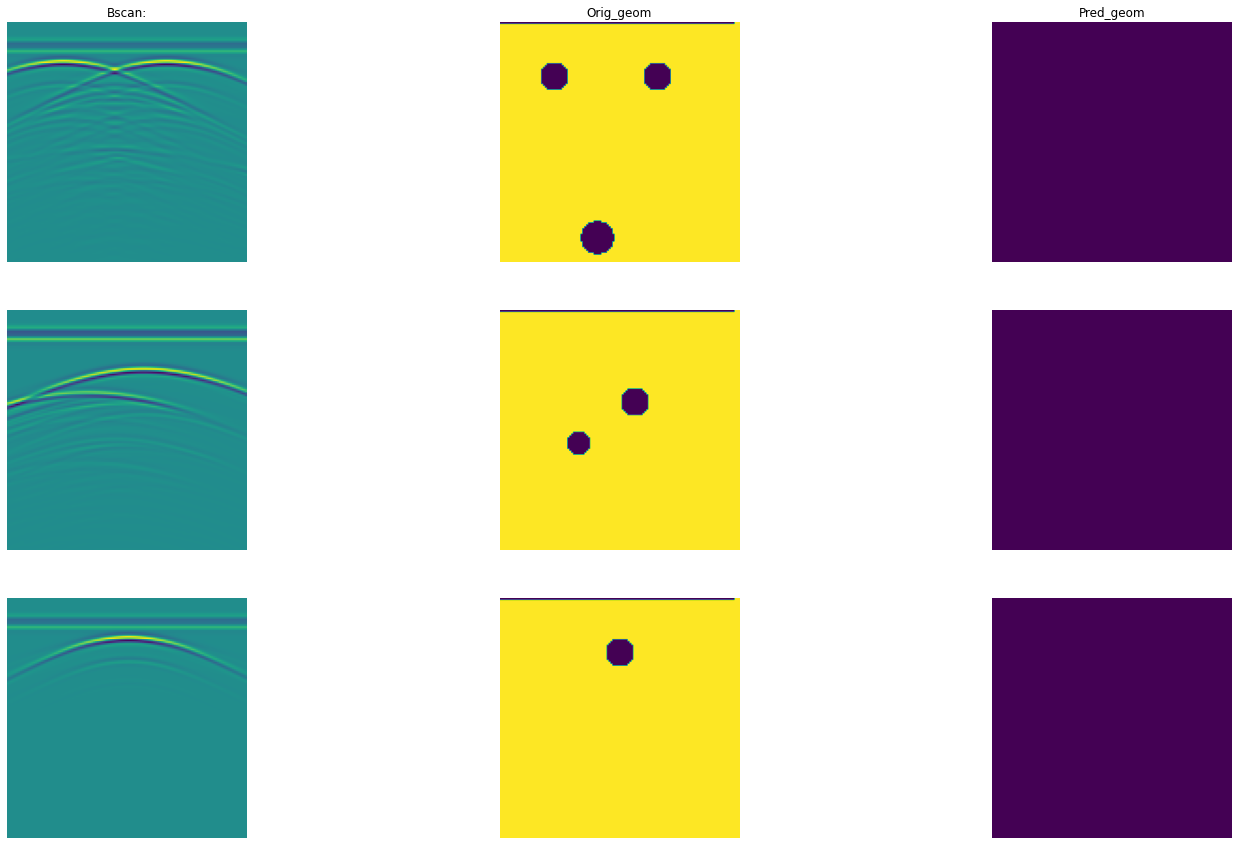

In [18]:
process_images(ae_faces)

## Нейронка 2 Simple

In [19]:
# input_shape[IMG_HEIGHT, IMG_WIDTH,1]
CLASS_COUNT = 1
# Функция визуализации процесса сегментации изображений



def sequential_segmentation_net(class_count,  # количество классов
                                input_shape   # форма входного изображения
                                ):

    img_input = Input(input_shape)                                              # Создаем входной слой формой input_shape
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)   

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv3')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv4')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)     

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv5')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)           
       
    x = Conv2D(class_count, (3, 3), activation='linear', padding='same')(x)    # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                                 # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae'],
                  )
    
    # Возвращаем сформированную модель
    return model 

# Создание модели и вывод сводки по архитектуре

model_seq = sequential_segmentation_net(CLASS_COUNT,
                                       (IMG_WIDTH, IMG_HEIGHT, 1))

# model_seq.summary()



In [ ]:
# Обучение модели

history = model_seq.fit(X_train, y_train,
                        epochs=50, batch_size=12,
                        validation_data=(X_test, y_test))

Epoch 1/50
65/65 [==============================] - 275s 4s/step - loss: 6.5135 - val_loss: 4.8562
Epoch 2/50
65/65 [==============================] - 265s 4s/step - loss: 3.6608 - val_loss: 4.8793
Epoch 3/50
65/65 [==============================] - 267s 4s/step - loss: 3.5192 - val_loss: 4.1879
Epoch 4/50
65/65 [==============================] - 266s 4s/step - loss: 3.4749 - val_loss: 3.6501
Epoch 5/50
65/65 [==============================] - 265s 4s/step - loss: 3.4355 - val_loss: 3.6766
Epoch 6/50
65/65 [==============================] - 265s 4s/step - loss: 3.4174 - val_loss: 3.3412
Epoch 7/50
65/65 [==============================] - 266s 4s/step - loss: 3.3448 - val_loss: 3.4742
Epoch 8/50
65/65 [==============================] - 265s 4s/step - loss: 3.2597 - val_loss: 3.2442
Epoch 9/50
65/65 [==============================] - 267s 4s/step - loss: 3.1999 - val_loss: 3.0671
Epoch 10/50
65/65 [==============================] - 266s 4s/step - loss: 3.1083 - val_loss: 3.0128
Epoch 11/

1/1 [==============================] - 0s 88ms/step


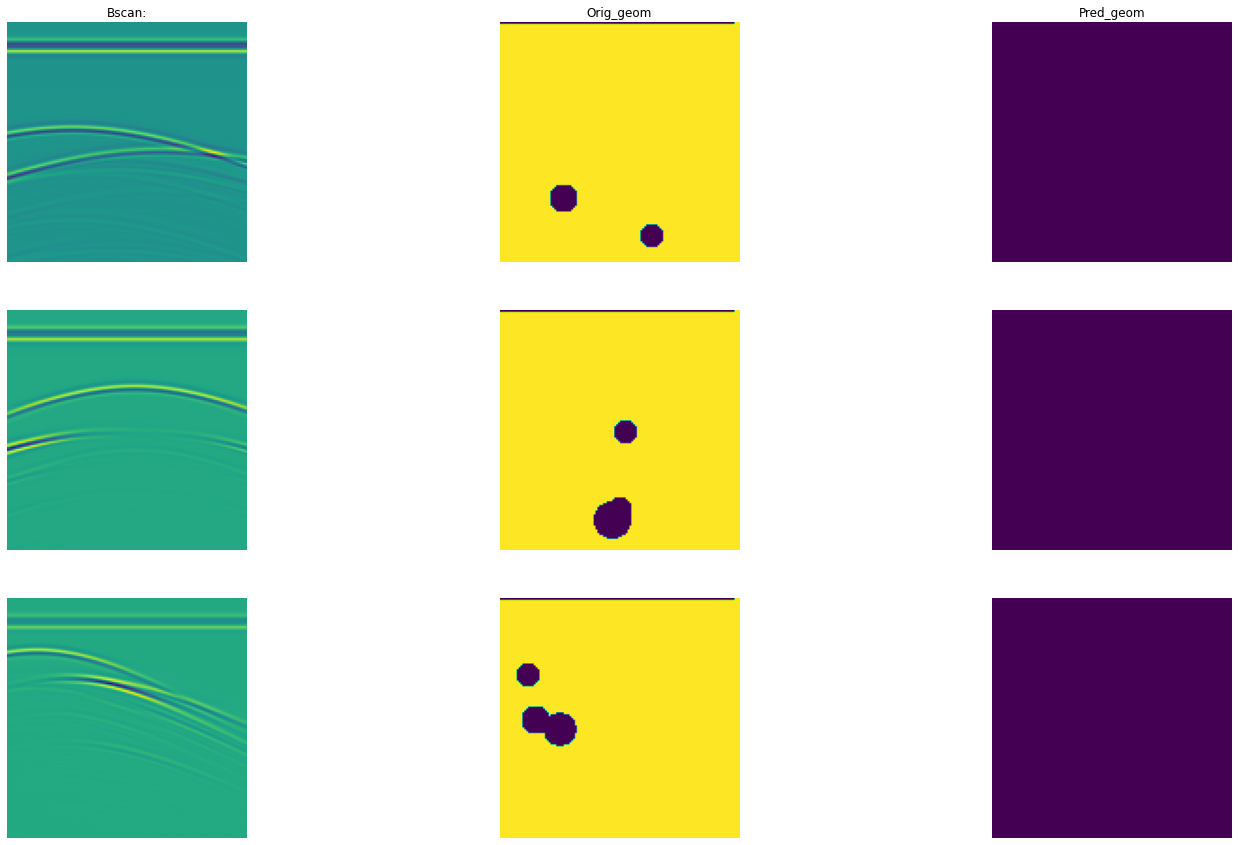

In [21]:
process_images(model_seq)

# Нейронка 3 Unet для увеличения разрешения

## Dataset

In [21]:
def load_bscans(folder, height, width): 
    bscans_list = []                       # Список для радарограмм
    geometry_list = []
    for bscan in os.listdir(folder):        # Перебор по именам файлов в папке
        # Добавление в список изображения в виде массива,
        # в заданных размерах и в оттенках серого
        if 'bscan_' in bscan:
            bscans_list.append(zoom(np.load(os.path.join(folder, bscan)), (1,0.25)).T)
            # print(folder+'\\'+bscan)
            geom_name=f'geom{bscan[5:-4]}.npy'
            geom_np = np.load(os.path.join(folder, geom_name))
            new_geom = np.zeros((128, 128, 2),)
            new_geom[:,:,0] = 6 # наиболее часто встречающееся число
            new_geom[:,:,1] = 1 # наиболее часто встречающееся число
            new_geom[:126,:125,:2] = geom_np
            
            geometry_list.append(new_geom)
                
            
    # Возврат массива-результата
    return np.array(bscans_list), np.array(geometry_list)

# Загрузка датасета в память
cur_time = time.time()
data_bscans, data_geometry = load_bscans(folder, IMG_HEIGHT, IMG_WIDTH)
print(f'Время загрузки: {round(time.time()-cur_time)} с.')
data_bscans = data_bscans.reshape([data_bscans.shape[0], 
                                   data_bscans.shape[1], 
                                   data_bscans.shape[2], 
                                   1])
data_geometry = data_geometry[:,:,:,0].reshape([data_bscans.shape[0], 
                                   data_bscans.shape[1], 
                                   data_bscans.shape[2], 
                                   1])
